In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import os
import random as rng
from tqdm import tqdm
%matplotlib inline

rng.seed(12345)

In [6]:
# path
figure_log_root = Path('/cluster/scratch/jingyli/interpretable/visualization')

In [7]:
def read_watershed_results(DATE, TIME, CHANNEL, W, MODEL):
    filename = f"{DATE}_{TIME}_C{CHANNEL}-W{W}.npy"
    filepath = figure_log_root / f"{MODEL}" / f"{DATE}_{TIME}" / "watershed"/ filename
    if os.path.exists(filepath):
        arr = np.load(filepath)
        return arr
    else:
        return None


In [12]:
MODEL = "resUnet"
DATE = "2019-07-01"
TIME = 144
CHANNEL = 0

# To store multiple watershed marker layers
watershed_layer = []

idx = 1
for i in tqdm(range(1,22,2)):
    for j in range(0,22,2):
        W = f"{i}_{j}"
        arr = read_watershed_results(DATE, TIME, CHANNEL, W, MODEL)
        if arr is None:
            continue
        markers = arr[...,0]
        markers = np.where((markers > 0) & (markers < 255), idx, 0)
        watershed_layer.append(markers)
        idx += 1
watershed_layer = np.array(watershed_layer)
print(f"Loaded {len(watershed_layer)} in total")

100%|██████████| 11/11 [00:00<00:00, 48.57it/s]

Loaded 49 in total


In [9]:
np.unique(watershed_layer, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([2055613,    1511,     412,    1274,    1168,    1385,    1722,
            430,     410,     459]))

In [13]:
# Add colors

# Generate random colors
colors = []
for i in range(watershed_layer.shape[0]):
    colors.append((rng.randint(0, 256), rng.randint(0, 256), rng.randint(0, 256)))
    
# Create the result image
dst = np.ones((watershed_layer.shape[1], watershed_layer.shape[2], 4), dtype=np.uint8) * 255
# dst[..., 3] = np.ones(watershed_layer.shape[1:])*100
# Fill labeled objects with random colors
for i in range(watershed_layer.shape[1]):
    for j in range(watershed_layer.shape[2]):
        # Filter layers where has marker
        layers = watershed_layer[:, i, j]
        markers = np.unique(layers[np.nonzero(layers)])
        if len(markers)==0:
            continue
        index = markers[-1]
        dst[i, j, :3] = colors[index - 1]

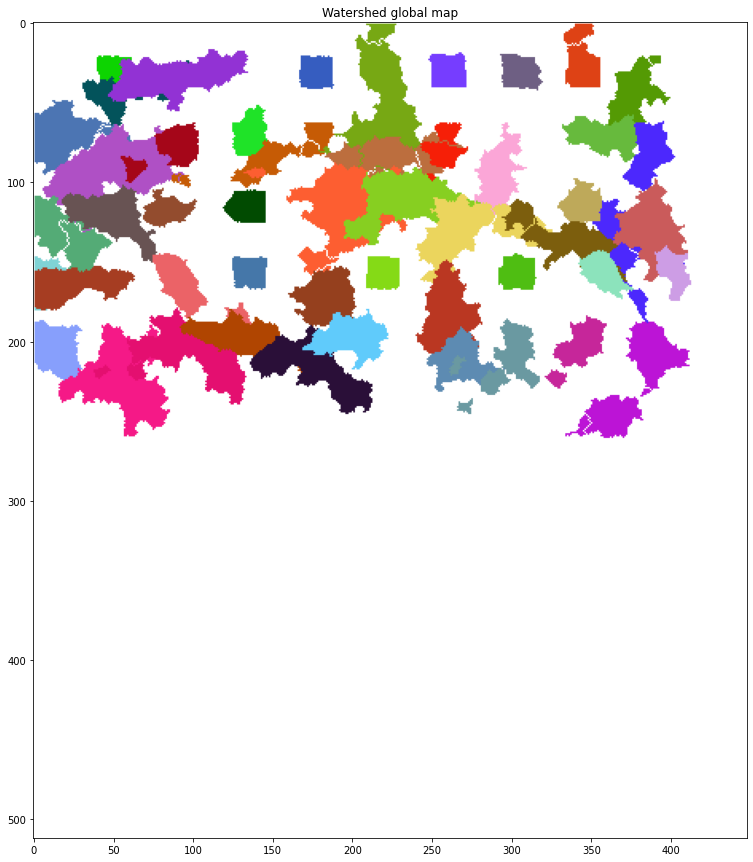

In [14]:
# Visualize the final image
fig, ax = plt.subplots(1,1, figsize=(15,15))
im = ax.imshow(dst)
ax.set_title(f"Watershed global map")
plt.show()